# Online News Popularity Analysis using Pyspark


In [1]:
#import the necessary libries
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.sql import SparkSession
import pandas as pd

### * Loading data

In [2]:
# Create SparkSession object
spark = SparkSession.builder.appName('OnlineNewsPopularity').getOrCreate()

# read a csv file
my_data = spark.read.csv('OnlineNewsPopularity.csv',header=True)

21/07/09 06:01:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### * Schema

In [3]:
# see the default schema of the dataframe
my_data.printSchema()

root
 |-- url: string (nullable = true)
 |--  timedelta: string (nullable = true)
 |--  n_tokens_title: string (nullable = true)
 |--  n_tokens_content: string (nullable = true)
 |--  n_unique_tokens: string (nullable = true)
 |--  n_non_stop_words: string (nullable = true)
 |--  n_non_stop_unique_tokens: string (nullable = true)
 |--  num_hrefs: string (nullable = true)
 |--  num_self_hrefs: string (nullable = true)
 |--  num_imgs: string (nullable = true)
 |--  num_videos: string (nullable = true)
 |--  average_token_length: string (nullable = true)
 |--  num_keywords: string (nullable = true)
 |--  data_channel_is_lifestyle: string (nullable = true)
 |--  data_channel_is_entertainment: string (nullable = true)
 |--  data_channel_is_bus: string (nullable = true)
 |--  data_channel_is_socmed: string (nullable = true)
 |--  data_channel_is_tech: string (nullable = true)
 |--  data_channel_is_world: string (nullable = true)
 |--  kw_min_min: string (nullable = true)
 |--  kw_max_min: st

In [4]:
spark

### * Data dimension

In [7]:
# get the dimensions of the data
(my_data.count() , len(my_data.columns))

(39644, 61)

In [8]:
my_data.show(10)

21/07/09 06:07:48 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+----------+---------------+-----------------+----------------+-----------------+-------------------------+----------+---------------+---------+-----------+---------------------+-------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------------+--------------------------+---------------------------+------------------+-------------------+---------------------+--------------------+------------------+--------------------+------------------+-----------+----------------+----------------+----------------+----------------+----------------+--------------------+--------------------------+---------------------------+---------------------------+--------------------+--------------------+----------------------+----------------------+-------------------

### * Cloumns in Dataset

In [8]:
my_data.columns

['url',
 ' timedelta',
 ' n_tokens_title',
 ' n_tokens_content',
 ' n_unique_tokens',
 ' n_non_stop_words',
 ' n_non_stop_unique_tokens',
 ' num_hrefs',
 ' num_self_hrefs',
 ' num_imgs',
 ' num_videos',
 ' average_token_length',
 ' num_keywords',
 ' data_channel_is_lifestyle',
 ' data_channel_is_entertainment',
 ' data_channel_is_bus',
 ' data_channel_is_socmed',
 ' data_channel_is_tech',
 ' data_channel_is_world',
 ' kw_min_min',
 ' kw_max_min',
 ' kw_avg_min',
 ' kw_min_max',
 ' kw_max_max',
 ' kw_avg_max',
 ' kw_min_avg',
 ' kw_max_avg',
 ' kw_avg_avg',
 ' self_reference_min_shares',
 ' self_reference_max_shares',
 ' self_reference_avg_sharess',
 ' weekday_is_monday',
 ' weekday_is_tuesday',
 ' weekday_is_wednesday',
 ' weekday_is_thursday',
 ' weekday_is_friday',
 ' weekday_is_saturday',
 ' weekday_is_sunday',
 ' is_weekend',
 ' LDA_00',
 ' LDA_01',
 ' LDA_02',
 ' LDA_03',
 ' LDA_04',
 ' global_subjectivity',
 ' global_sentiment_polarity',
 ' global_rate_positive_words',
 ' global_

### * Null Valures

In [36]:
nul_col=my_data.select([count(when(col(c).isNull(), c)).alias(c) for c in my_data.columns]).toPandas()
pd.set_option("display.max_rows", None, "display.max_columns", None)
nul_col.T

,0
url,0
timedelta,0
n_tokens_title,0
n_tokens_content,0
n_unique_tokens,0
n_non_stop_words,0
n_non_stop_unique_tokens,0
num_hrefs,0
num_self_hrefs,0
num_imgs,0


### * Cast method

In [38]:
from pyspark.sql.types import IntegerType
cols = [' n_tokens_title',
 ' n_tokens_content',
 ' n_unique_tokens',
 ' n_non_stop_words',
 ' n_non_stop_unique_tokens',
 ' num_hrefs',
 ' num_self_hrefs',
 ' num_imgs',
 ' num_videos',
 ' average_token_length',
 ' num_keywords',
 ' data_channel_is_lifestyle',
 ' data_channel_is_entertainment',
 ' data_channel_is_bus',
 ' data_channel_is_socmed',
 ' data_channel_is_tech',
 ' data_channel_is_world',
 ' kw_min_min',
 ' kw_max_min',
 ' kw_avg_min',
 ' kw_min_max',
 ' kw_max_max',
 ' kw_avg_max',
 ' kw_min_avg',
 ' kw_max_avg',
 ' kw_avg_avg',
 ' self_reference_min_shares',
 ' self_reference_max_shares',
 ' self_reference_avg_sharess',
 ' weekday_is_monday',
 ' weekday_is_tuesday',
 ' weekday_is_wednesday',
 ' weekday_is_thursday',
 ' weekday_is_friday',
 ' weekday_is_saturday',
 ' weekday_is_sunday',
 ' is_weekend',
 ' LDA_00',
 ' LDA_01',
 ' LDA_02',
 ' LDA_03',
 ' LDA_04',
 ' global_subjectivity',
 ' global_sentiment_polarity',
 ' global_rate_positive_words',
 ' global_rate_negative_words',
 ' rate_positive_words',
 ' rate_negative_words',
 ' avg_positive_polarity',
 ' min_positive_polarity',
 ' max_positive_polarity',
 ' avg_negative_polarity',
 ' min_negative_polarity',
 ' max_negative_polarity',
 ' title_subjectivity',
 ' title_sentiment_polarity',
 ' abs_title_subjectivity',
 ' abs_title_sentiment_polarity']
for col_name in cols:
    my_data = my_data.withColumn(col_name, col(col_name).cast('float'))

In [39]:
# see the default schema of the dataframe (float)
my_data.printSchema()

root
 |-- url: string (nullable = true)
 |--  timedelta: string (nullable = true)
 |--  n_tokens_title: float (nullable = true)
 |--  n_tokens_content: float (nullable = true)
 |--  n_unique_tokens: float (nullable = true)
 |--  n_non_stop_words: float (nullable = true)
 |--  n_non_stop_unique_tokens: float (nullable = true)
 |--  num_hrefs: float (nullable = true)
 |--  num_self_hrefs: float (nullable = true)
 |--  num_imgs: float (nullable = true)
 |--  num_videos: float (nullable = true)
 |--  average_token_length: float (nullable = true)
 |--  num_keywords: float (nullable = true)
 |--  data_channel_is_lifestyle: float (nullable = true)
 |--  data_channel_is_entertainment: float (nullable = true)
 |--  data_channel_is_bus: float (nullable = true)
 |--  data_channel_is_socmed: float (nullable = true)
 |--  data_channel_is_tech: float (nullable = true)
 |--  data_channel_is_world: float (nullable = true)
 |--  kw_min_min: float (nullable = true)
 |--  kw_max_min: float (nullable = tr

In [40]:
my_data = my_data.withColumn(" shares", my_data[" shares"].cast(IntegerType()))

In [42]:
# see the datatype
display(my_data)

DataFrame[url: string,  timedelta: string,  n_tokens_title: float,  n_tokens_content: float,  n_unique_tokens: float,  n_non_stop_words: float,  n_non_stop_unique_tokens: float,  num_hrefs: float,  num_self_hrefs: float,  num_imgs: float,  num_videos: float,  average_token_length: float,  num_keywords: float,  data_channel_is_lifestyle: float,  data_channel_is_entertainment: float,  data_channel_is_bus: float,  data_channel_is_socmed: float,  data_channel_is_tech: float,  data_channel_is_world: float,  kw_min_min: float,  kw_max_min: float,  kw_avg_min: float,  kw_min_max: float,  kw_max_max: float,  kw_avg_max: float,  kw_min_avg: float,  kw_max_avg: float,  kw_avg_avg: float,  self_reference_min_shares: float,  self_reference_max_shares: float,  self_reference_avg_sharess: float,  weekday_is_monday: float,  weekday_is_tuesday: float,  weekday_is_wednesday: float,  weekday_is_thursday: float,  weekday_is_friday: float,  weekday_is_saturday: float,  weekday_is_sunday: float,  is_weeken

### * Feature extraction

In [51]:
# String Split of the column in pyspark
from pyspark.sql.functions import split, count, when, col

split_col = split(my_data['url'], '/')
my_data = my_data.withColumn('articles', split_col.getItem(6))

Extracted article names from the url column using split_col

In [52]:
my_data.select('articles').distinct().count()

39644

All the articles are distinct

In [53]:
my_data_pd =split_data.toPandas()
art = my_data_pd[['articles', ' shares']]
art_sorted = art.sort_values([" shares", "articles"], ascending=False)
art_sorted.head(5)

,articles,shares
9365,low-cost-iphone,843300
5370,dove-ad-beauty-sketches,690400
23237,first-100-gilt-soundcloud-stitchfix,663600
16268,kanye-west-harvard-lecture,652900
3145,wealth-inequality,617900


Low-cost-iphone article was the top one

### * Dropping non-predictive column

In [54]:
my_data = my_data.drop(*['url',' timedelta'])

my_data.columns

[' n_tokens_title',
 ' n_tokens_content',
 ' n_unique_tokens',
 ' n_non_stop_words',
 ' n_non_stop_unique_tokens',
 ' num_hrefs',
 ' num_self_hrefs',
 ' num_imgs',
 ' num_videos',
 ' average_token_length',
 ' num_keywords',
 ' data_channel_is_lifestyle',
 ' data_channel_is_entertainment',
 ' data_channel_is_bus',
 ' data_channel_is_socmed',
 ' data_channel_is_tech',
 ' data_channel_is_world',
 ' kw_min_min',
 ' kw_max_min',
 ' kw_avg_min',
 ' kw_min_max',
 ' kw_max_max',
 ' kw_avg_max',
 ' kw_min_avg',
 ' kw_max_avg',
 ' kw_avg_avg',
 ' self_reference_min_shares',
 ' self_reference_max_shares',
 ' self_reference_avg_sharess',
 ' weekday_is_monday',
 ' weekday_is_tuesday',
 ' weekday_is_wednesday',
 ' weekday_is_thursday',
 ' weekday_is_friday',
 ' weekday_is_saturday',
 ' weekday_is_sunday',
 ' is_weekend',
 ' LDA_00',
 ' LDA_01',
 ' LDA_02',
 ' LDA_03',
 ' LDA_04',
 ' global_subjectivity',
 ' global_sentiment_polarity',
 ' global_rate_positive_words',
 ' global_rate_negative_words',
 

In [55]:
my_data.groupBy(' shares').count().show()

+-------+-----+
| shares|count|
+-------+-----+
|   4900|  119|
|   5300|  103|
|    463|    7|
|    833|   32|
|    471|   11|
|    496|   11|
|   9900|   27|
|  21700|    7|
|  18800|   12|
| 111300|    1|
| 109800|    1|
|  11500|   27|
|    737|   20|
|    623|   15|
|  16500|    9|
|    858|   20|
|  19200|    7|
|    392|    3|
|  35800|    2|
|    897|   25|
+-------+-----+
only showing top 20 rows



### * Descriptive statistics

In [57]:
my_data.describe().toPandas()

,summary,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,articles
0,count,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644
1,mean,10.398748864897588,546.514731106851,0.5482157174965431,0.9964685701641928,0.689175394840216,10.883689839572192,3.2936383815962063,4.544142871556856,1.2498738775098375,4.5482393178313405,7.223766522046211,0.05294622137019473,0.17800928261527596,0.15785490868731714,0.0585965089294723,0.1852991625466653,0.21256684491978609,26.10680052466956,1153.9516822218673,312.366966757532,13612.35410150338,752324.0666935728,259281.93815059005,1117.1466100852674,5657.2111520437165,3135.8586380956344,3998.7553955201374,10329.21266194128,6401.6975800678,0.16802038139441025,0.18640904046009485,0.18754414287155685,0.18330642720209867,0.14380486328322067,0.06187569367369589,0.06903945111492281,0.1309151447886187,0.18459904832615487,0.14125577311147383,0.2163209667737639,0.22376961652972252,0.23402937082855677,0.4433701996558653,0.11930926930603165,0.039624833095614,0.016612119566041403,0.6821502246230994,0.2879335273086658,0.3538249434489614,0.09544553975260348,0.7567275468383713,-0.2595241414509207,-0.5219437318149317,-0.10750024184564791,0.2823531853798399,0.07142543236588027,0.3418427571011275,0.15606366404967073,3395.3801836343455,None
2,stddev,2.1140368083035366,471.10750794805705,3.520708331255675,5.231230945152293,3.264816354819172,11.332017376010894,3.8551411453744477,8.309433519603694,4.10785508622367,0.8444055648858871,1.9091303859707005,0.22392897060157427,0.3825253833533383,0.3646095032190893,0.2348709210689517,0.3885449664810777,0.40912883496356245,69.63321512144343,3857.9908765299897,620.7838845118372,57986.02935737183,214502.129572766,135102.24740615024,1137.4569508533164,6098.871955833617,1318.1503992026594,19738.670516259914,41027.5766129217,24211.332224570026,0.37388909992166025,0.3894413123393897,0.39035263664228226,0.3869224176521677,0.35089618183245924,0.24093268033164955,0.25352441026430783,0.33731178407787804,0.26297470928410416,0.21970732884691047,0.2821452039006741,0.29519073352989883,0.2891834781242963,0.11668464251794916,0.09693066125607704,0.017428657915793698,0.010827792213604201,0.19020632390757178,0.15615588925945242,0.1045421882997773,0.07131493229909719,0.24778571684334347,0.12772572206700797,0.2902895020205918,0.09537298573973041,0.3242473751886127,0.2654502304581731,0.18879080408372265,0.22629419857935443,11626.950748651721,None
3,min,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.39375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,1,1-5-million-christmas-lights


### * Distribution

In [58]:
# Converting to Dataframe
data = my_data.toPandas()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


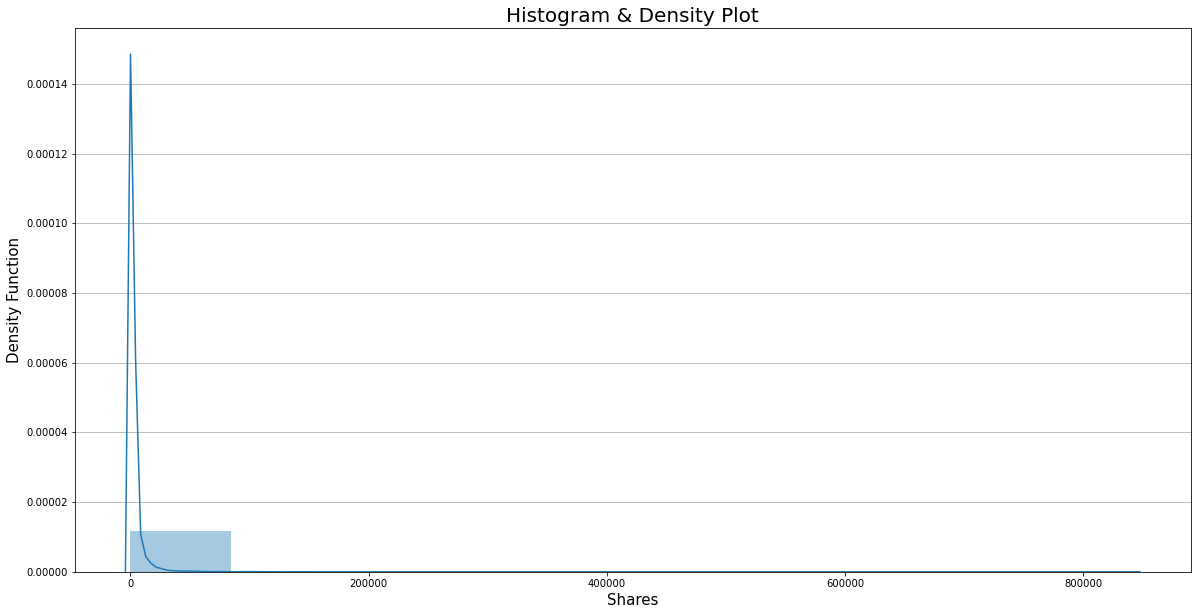

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))
sns.distplot(data[' shares'],            
             hist = True, bins=10, 
             kde=True, color='#1F78B4'
            )
## KDE stands for Kernel Density Estimate

plt.title("Histogram & Density Plot", fontsize=20)
plt.xlabel('Shares', fontsize=15)
plt.ylabel('Density Function', fontsize=15)
plt.grid(axis='y')

### * Data Analysis

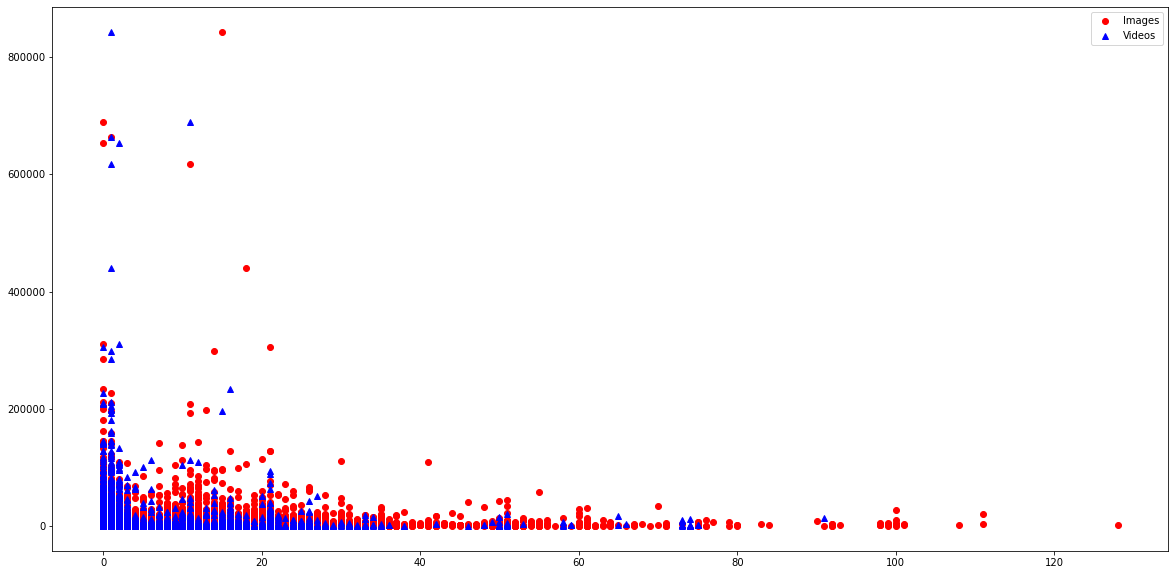

In [63]:
plt.figure(figsize=(20,10))
plt.plot(data[' num_imgs'],data[' shares'],'ro',label='Images')
plt.plot(data[' num_videos'],data[' shares'],'b^',label='Videos')
plt.legend()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel=' n_tokens_content', ylabel=' shares'>

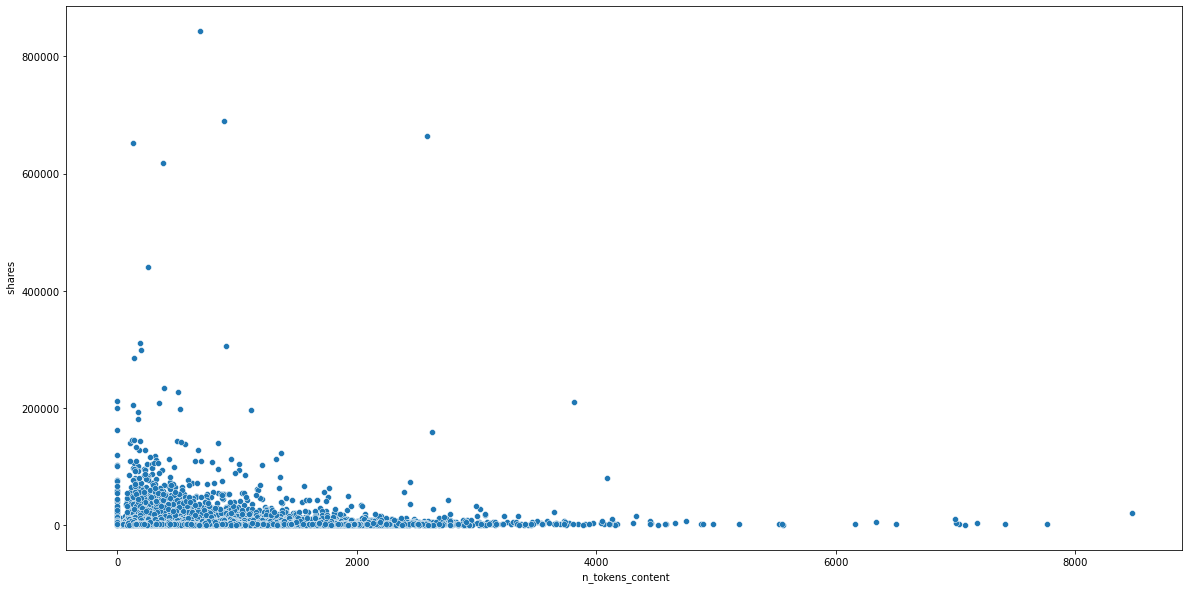

In [65]:
plt.figure(figsize=(20,10))
sns.scatterplot(data[' n_tokens_content'],data[' shares'])

Total words in the content between 0-2000 are getting the higher response.Above 2000 articles have not been shared more number of times.

Data is right skewed

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel=' num_keywords', ylabel=' shares'>

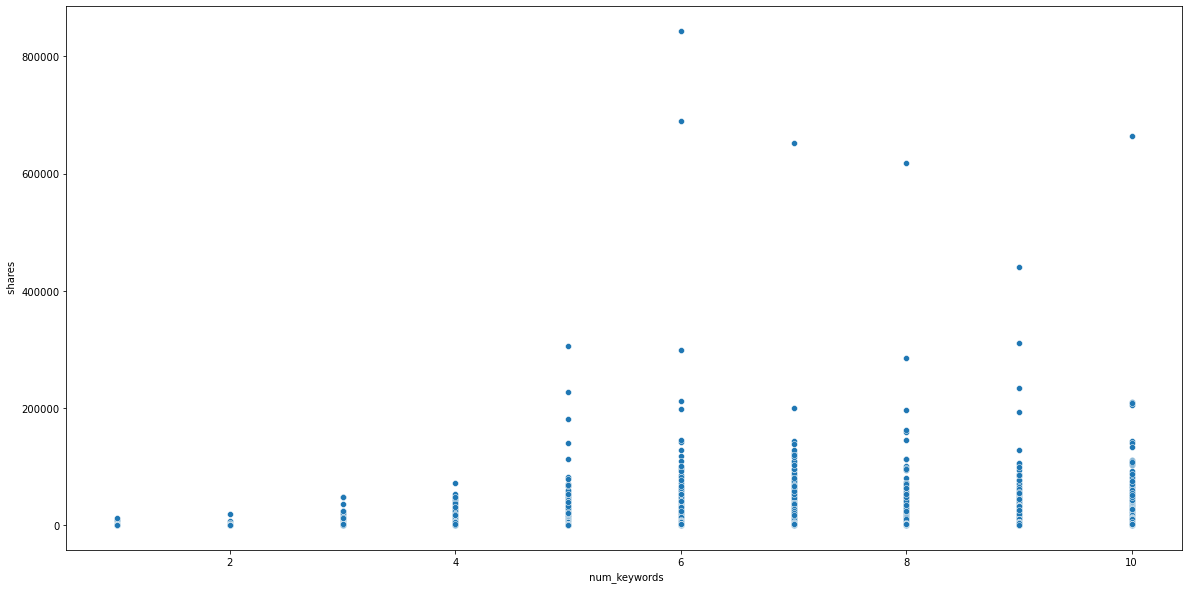

In [66]:
plt.figure(figsize=(20,10))
sns.scatterplot(data[' num_keywords'],data[' shares'])

Number of share is less when the number of keywords in the metadata is between 0 to 4

### * Combining columns for data visualization

In [67]:
df = data[[' data_channel_is_lifestyle', ' data_channel_is_entertainment', ' data_channel_is_bus', ' data_channel_is_socmed', ' data_channel_is_tech', ' data_channel_is_world']]

In [68]:
def get_data_channel(row):
    for c in df.columns:
        if row[c]==1:
            return c
        
data_channel = df.apply(get_data_channel, axis=1)

In [69]:
data['data_channel'] = data_channel

In [70]:
data["data_channel"].fillna("data_channel_is_other", inplace = True)

In [71]:
data.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,articles,data_channel
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,amazon-instant-video-browser,data_channel_is_entertainment
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,ap-samsung-sponsored-tweets,data_channel_is_bus
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,apple-40-billion-app-downloads,data_channel_is_bus
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,astronaut-notre-dame-bcs,data_channel_is_entertainment
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157959,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,att-u-verse-apps,data_channel_is_tech


<AxesSubplot:xlabel='data_channel', ylabel=' shares'>

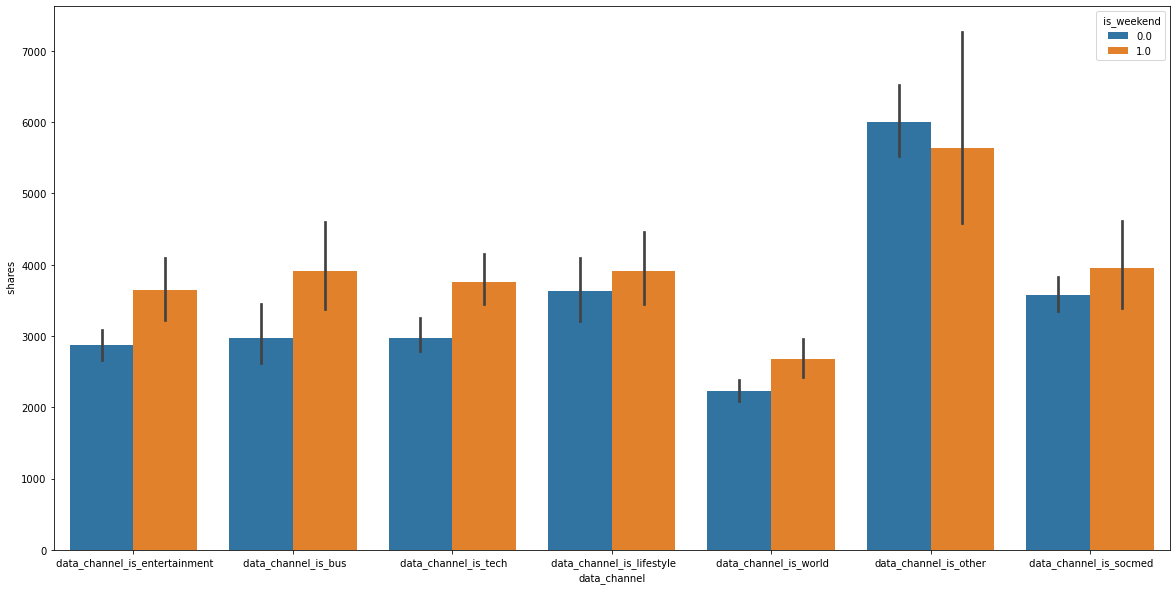

In [72]:
plt.figure(figsize=(20,10))
#plt.bar(data['data_channel'],data[' shares'])
sns.barplot(x=data['data_channel'], y= data[' shares'], hue=data[' is_weekend'])

Most of the articles are shared at the weekend 

In [73]:
df1 = data[[' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday', ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday', ' weekday_is_sunday']]

In [74]:
def get_weekday(row):
    for c in df1.columns:
        if row[c]==1:
            return c
        
weekday = df1.apply(get_weekday, axis=1)

In [75]:
data['weekday'] = weekday

<BarContainer object of 39644 artists>

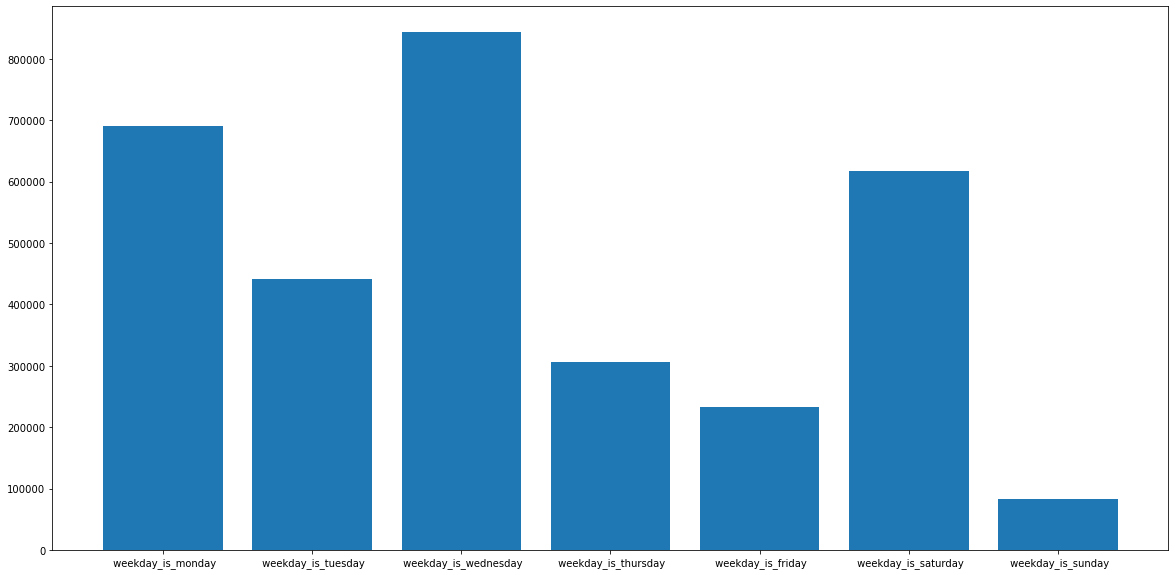

In [76]:
plt.figure(figsize=(20,10))
plt.bar(data['weekday'],data[' shares'])

Number of shares are high at monday, wednesday and saturday

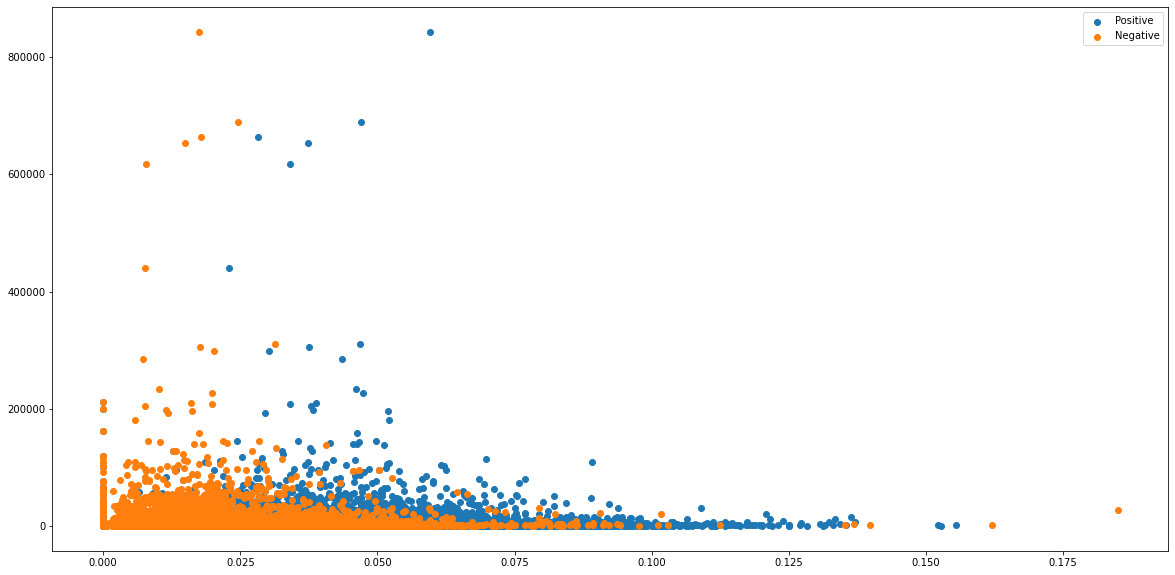

In [77]:
plt.figure(figsize=(20,10))
plt.scatter(data[' global_rate_positive_words'],data[' shares'],label='Positive')
plt.scatter(data[' global_rate_negative_words'],data[' shares'],label='Negative')
plt.legend()

From the above scatter plot it is clear that the rate of positive words is slightly higher than negative words

### * Correlation matrix

In [80]:
numeric_cols = [' n_tokens_title',
 ' n_tokens_content',
 ' n_unique_tokens',
 ' n_non_stop_words',
 ' n_non_stop_unique_tokens',
 ' num_hrefs',
 ' num_self_hrefs',
 ' num_imgs',
 ' num_videos',
 ' average_token_length',
 ' num_keywords',
 ' data_channel_is_lifestyle',
 ' data_channel_is_entertainment',
 ' data_channel_is_bus',
 ' data_channel_is_socmed',
 ' data_channel_is_tech',
 ' data_channel_is_world',
 ' kw_min_min',
 ' kw_max_min',
 ' kw_avg_min',
 ' kw_min_max',
 ' kw_max_max',
 ' kw_avg_max',
 ' kw_min_avg',
 ' kw_max_avg',
 ' kw_avg_avg',
 ' self_reference_min_shares',
 ' self_reference_max_shares',
 ' self_reference_avg_sharess',
 ' weekday_is_monday',
 ' weekday_is_tuesday',
 ' weekday_is_wednesday',
 ' weekday_is_thursday',
 ' weekday_is_friday',
 ' weekday_is_saturday',
 ' weekday_is_sunday',
 ' is_weekend',
 ' LDA_00',
 ' LDA_01',
 ' LDA_02',
 ' LDA_03',
 ' LDA_04',
 ' global_subjectivity',
 ' global_sentiment_polarity',
 ' global_rate_positive_words',
 ' global_rate_negative_words',
 ' rate_positive_words',
 ' rate_negative_words',
 ' avg_positive_polarity',
 ' min_positive_polarity',
 ' max_positive_polarity',
 ' avg_negative_polarity',
 ' min_negative_polarity',
 ' max_negative_polarity',
 ' title_subjectivity',
 ' title_sentiment_polarity',
 ' abs_title_subjectivity',
 ' abs_title_sentiment_polarity',
 ' shares']

In [81]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=numeric_cols, 
                            outputCol=vector_col)
df_vector = assembler.transform(my_data).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

21/07/09 08:25:55 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/07/09 08:25:55 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


<AxesSubplot:>

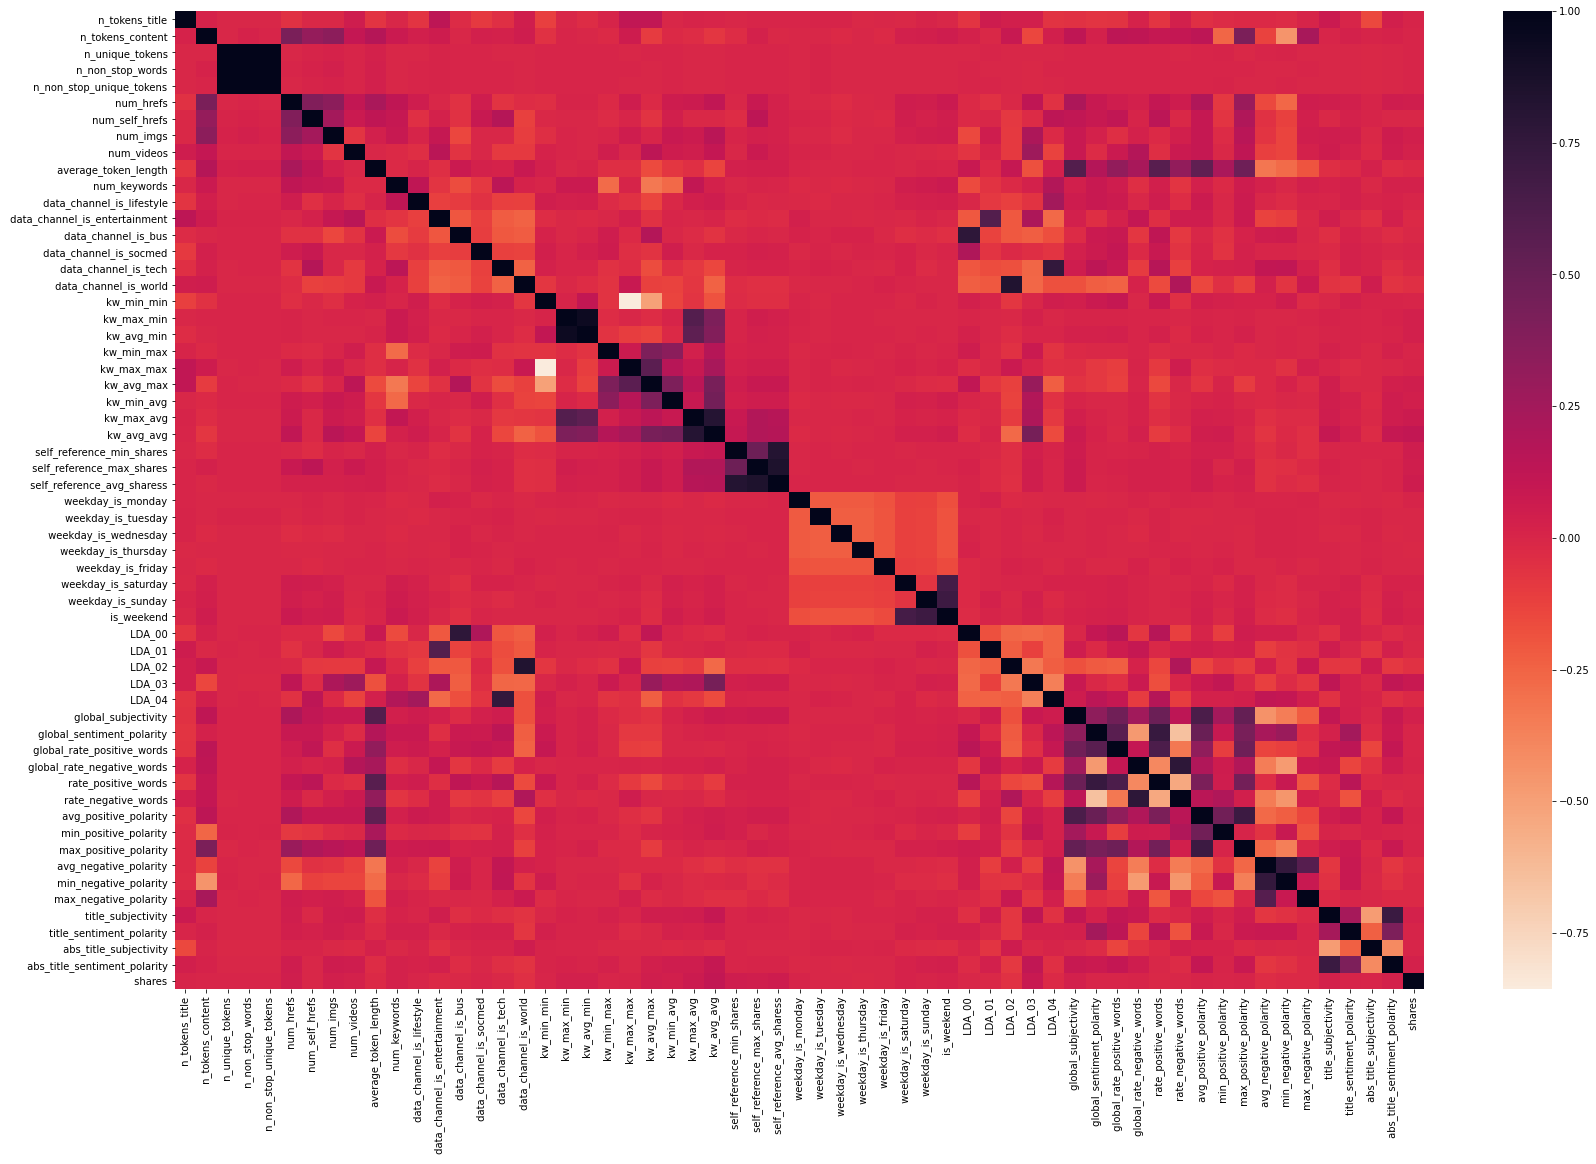

In [82]:
import seaborn as sns
from matplotlib.pyplot import figure

figure(figsize=(28, 18))
sns.heatmap(corrmatrix, 
            xticklabels=numeric_cols,
            yticklabels=numeric_cols,
            cmap=sns.cm.rocket_r
           )

In [83]:
pd.DataFrame(corrmatrix, columns=numeric_cols, index=numeric_cols)

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
n_tokens_title,1.000000,0.018160,-0.005318,-0.004754,-0.005420,-0.053496,-0.014856,-0.008858,0.051460,-0.071403,-0.006077,-0.070815,0.132791,-0.023902,-0.090394,-0.046716,0.049223,-0.110672,-0.005890,-0.031400,0.012926,0.120841,0.115746,-0.002370,0.006918,0.004296,-0.004563,0.000128,0.000661,0.004274,0.009322,0.008935,-0.015472,-0.002015,-0.015013,0.006289,-0.005996,-0.070038,0.063568,0.038365,0.042208,-0.065063,-0.056804,-0.072226,-0.064951,0.015530,-0.066589,0.034186,-0.049619,-0.025069,-0.021662,-0.017096,-0.029146,0.011425,0.077245,0.000240,-0.146954,0.040550,0.008783
n_tokens_content,0.018160,1.000000,-0.004737,0.017512,0.000373,0.423065,0.304682,0.342600,0.103699,0.167789,0.072845,0.037548,0.060200,-0.006105,0.033424,0.025408,0.055989,-0.054345,0.000066,-0.003545,-0.022786,0.058860,-0.096460,-0.022286,-0.030496,-0.079624,-0.030686,0.025657,-0.013809,-0.002484,-0.004027,-0.016891,-0.007395,-0.015949,0.034538,0.036394,0.052024,0.026218,-0.009724,0.087266,-0.140141,0.041265,0.127879,0.021937,0.133979,0.125013,0.098960,0.101053,0.135123,-0.261493,0.415706,-0.130375,-0.450603,0.225870,0.004484,0.023358,0.007136,0.013439,0.002459
n_unique_tokens,-0.005318,-0.004737,1.000000,0.999572,0.999852,-0.004352,0.006620,0.018802,-0.000597,0.026407,-0.003679,-0.001653,0.011016,-0.000264,-0.000945,-0.002328,-0.005535,0.001601,-0.000552,-0.000826,0.000577,-0.001624,0.000805,0.004563,-0.002120,-0.002083,0.001036,-0.000222,0.001992,-0.002142,0.010538,-0.002224,-0.002248,-0.001398,-0.002563,-0.001803,-0.003186,-0.002213,-0.000827,-0.006855,-0.003689,-0.004260,-0.000180,0.000523,0.000014,-0.000877,-0.000667,-0.001657,-0.000487,0.009193,-0.009054,0.001453,0.009902,-0.007315,-0.004678,-0.002333,-0.009242,-0.004217,0.000806
n_non_stop_words,-0.004754,0.017512,0.999572,1.000000,0.999532,0.005521,0.013598,0.028486,-0.000899,0.031554,-0.001439,-0.000314,0.010903,-0.000012,-0.000078,0.000061,-0.002702,-0.000352,-0.000595,-0.000892,-0.000553,0.000394,-0.002939,0.003284,-0.003408,-0.005415,0.000339,0.000170,0.001614,-0.002147,0.010501,-0.002517,-0.002360,-0.001963,-0.001508,-0.001338,-0.002082,-0.001031,-0.002869,-0.003286,-0.009761,-0.001072,0.002565,0.000831,0.001535,0.001036,0.002421,0.001245,0.002285,0.000904,0.002062,-0.001372,-0.001214,-0.000761,-0.005389,-0.001650,-0.008511,-0.004391,0.000443
n_non_stop_unique_tokens,-0.005420,0.000373,0.999852,0.999532,1.000000,-0.004983,0.007584,0.014230,-0.000963,0.034185,-0.004440,-0.000417,0.010554,0.001840,-0.000526,-0.000921,-0.003801,0.002001,-0.000615,-0.000644,-0.000089,-0.002032,-0.002006,0.002510,-0.003694,-0.005944,0.000989,-0.000077,0.002009,-0.002042,0.010510,-0.002070,-0.002283,-0.001301,-0.002623,-0.002167,-0.003502,0.000342,-0.000965,-0.004965,-0.009781,-0.002097,0.005498,0.002043,0.005002,0.002590,0.005258,0.001709,0.004671,0.008380,-0.002245,-0.001972,0.004318,-0.006708,-0.005860,-0.002910,-0.008572,-0.005342,0.000114
num_hrefs,-0.053496,0.423065,-0.004352,0.005521,-0

The number of unique words and number of non-stop-words and number of non-stop-unique tokens are strongly correlated which implies that they are strongly linearly dependent on each other. Same as the above case Kw-avg- min and kw-max-min are also strongly corelated.

### * Dropping columns which strong correlation 

In [84]:
my_data = my_data.drop(*[' n_non_stop_words',' n_unique_tokens',' kw_avg_min',' kw_avg_avg',' self_reference_avg_sharess'])

my_data.columns

[' n_tokens_title',
 ' n_tokens_content',
 ' n_non_stop_unique_tokens',
 ' num_hrefs',
 ' num_self_hrefs',
 ' num_imgs',
 ' num_videos',
 ' average_token_length',
 ' num_keywords',
 ' data_channel_is_lifestyle',
 ' data_channel_is_entertainment',
 ' data_channel_is_bus',
 ' data_channel_is_socmed',
 ' data_channel_is_tech',
 ' data_channel_is_world',
 ' kw_min_min',
 ' kw_max_min',
 ' kw_min_max',
 ' kw_max_max',
 ' kw_avg_max',
 ' kw_min_avg',
 ' kw_max_avg',
 ' self_reference_min_shares',
 ' self_reference_max_shares',
 ' weekday_is_monday',
 ' weekday_is_tuesday',
 ' weekday_is_wednesday',
 ' weekday_is_thursday',
 ' weekday_is_friday',
 ' weekday_is_saturday',
 ' weekday_is_sunday',
 ' is_weekend',
 ' LDA_00',
 ' LDA_01',
 ' LDA_02',
 ' LDA_03',
 ' LDA_04',
 ' global_subjectivity',
 ' global_sentiment_polarity',
 ' global_rate_positive_words',
 ' global_rate_negative_words',
 ' rate_positive_words',
 ' rate_negative_words',
 ' avg_positive_polarity',
 ' min_positive_polarity',
 ' m

In [86]:
my_data = my_data.drop(*['articles'])

### * Creating buckets for the target variable

In [94]:
# UDF
from pyspark.sql.functions import udf

#using lambda function
shares_udf = udf(lambda shares: 0 if shares <= 1400 else 1, IntegerType())
#apply udf on dataframe
data = my_data.withColumn("popularity", shares_udf(my_data[' shares']))

In [95]:
data.describe().toPandas()

,summary,n_tokens_title,n_tokens_content,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,self_reference_min_shares,self_reference_max_shares,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,popularity
0,count,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644
1,mean,10.398748864897588,546.514731106851,0.689175394840216,10.883689839572192,3.2936383815962063,4.544142871556856,1.2498738775098375,4.5482393178313405,7.223766522046211,0.05294622137019473,0.17800928261527596,0.15785490868731714,0.0585965089294723,0.1852991625466653,0.21256684491978609,26.10680052466956,1153.9516822218673,13612.35410150338,752324.0666935728,259281.93815059005,1117.1466100852674,5657.2111520437165,3998.7553955201374,10329.21266194128,0.16802038139441025,0.18640904046009485,0.18754414287155685,0.18330642720209867,0.14380486328322067,0.06187569367369589,0.06903945111492281,0.1309151447886187,0.18459904832615487,0.14125577311147383,0.2163209667737639,0.22376961652972252,0.23402937082855677,0.4433701996558653,0.11930926930603165,0.039624833095614,0.016612119566041403,0.6821502246230994,0.2879335273086658,0.3538249434489614,0.09544553975260348,0.7567275468383713,-0.2595241414509207,-0.5219437318149317,-0.10750024184564791,0.2823531853798399,0.07142543236588027,0.3418427571011275,0.15606366404967073,3395.3801836343455,0.4934416305115528
2,stddev,2.1140368083035366,471.10750794805705,3.264816354819172,11.332017376010894,3.8551411453744477,8.309433519603694,4.10785508622367,0.8444055648858871,1.9091303859707005,0.22392897060157427,0.3825253833533383,0.3646095032190893,0.2348709210689517,0.3885449664810777,0.40912883496356245,69.63321512144343,3857.9908765299897,57986.02935737183,214502.129572766,135102.24740615024,1137.4569508533164,6098.871955833617,19738.670516259914,41027.5766129217,0.37388909992166025,0.3894413123393897,0.39035263664228226,0.3869224176521677,0.35089618183245924,0.24093268033164955,0.25352441026430783,0.33731178407787804,0.26297470928410416,0.21970732884691047,0.2821452039006741,0.29519073352989883,0.2891834781242963,0.11668464251794916,0.09693066125607704,0.017428657915793698,0.010827792213604201,0.19020632390757178,0.15615588925945242,0.1045421882997773,0.07131493229909719,0.24778571684334347,0.12772572206700797,0.2902895020205918,0.09537298573973041,0.3242473751886127,0.2654502304581731,0.18879080408372265,0.22629419857935443,11626.950748651721,0.49996329164074166
3,min,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.39375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,1,0
4,max,23.0,8474.0,650.0,304.0,116.0,128.0,91.0,8.041533,10.0,1.0,1.0,1.0,1.0,1.0,1.0,377.0,298400.0,843300.0,843300.0,843300.0,3613.0398,298400.0,843300.0,843300.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.9269944,0.925947,0.91999906,0.92653376,0.9271908,1.0,0.7278409,0.1554878,0.1849315,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.

In [96]:
data = data.drop(*[' shares'])

1400 shares is selected as a threshold based on the density distribution plot.

### * VectorAssembler

In [97]:
data.columns

[' n_tokens_title',
 ' n_tokens_content',
 ' n_non_stop_unique_tokens',
 ' num_hrefs',
 ' num_self_hrefs',
 ' num_imgs',
 ' num_videos',
 ' average_token_length',
 ' num_keywords',
 ' data_channel_is_lifestyle',
 ' data_channel_is_entertainment',
 ' data_channel_is_bus',
 ' data_channel_is_socmed',
 ' data_channel_is_tech',
 ' data_channel_is_world',
 ' kw_min_min',
 ' kw_max_min',
 ' kw_min_max',
 ' kw_max_max',
 ' kw_avg_max',
 ' kw_min_avg',
 ' kw_max_avg',
 ' self_reference_min_shares',
 ' self_reference_max_shares',
 ' weekday_is_monday',
 ' weekday_is_tuesday',
 ' weekday_is_wednesday',
 ' weekday_is_thursday',
 ' weekday_is_friday',
 ' weekday_is_saturday',
 ' weekday_is_sunday',
 ' is_weekend',
 ' LDA_00',
 ' LDA_01',
 ' LDA_02',
 ' LDA_03',
 ' LDA_04',
 ' global_subjectivity',
 ' global_sentiment_polarity',
 ' global_rate_positive_words',
 ' global_rate_negative_words',
 ' rate_positive_words',
 ' rate_negative_words',
 ' avg_positive_polarity',
 ' min_positive_polarity',
 ' m

In [98]:
from pyspark.ml.feature import VectorAssembler

numericCols = [' n_tokens_title',
 ' n_tokens_content',
 ' n_non_stop_unique_tokens',
 ' num_hrefs',
 ' num_self_hrefs',
 ' num_imgs',
 ' num_videos',
 ' average_token_length',
 ' num_keywords',
 ' data_channel_is_lifestyle',
 ' data_channel_is_entertainment',
 ' data_channel_is_bus',
 ' data_channel_is_socmed',
 ' data_channel_is_tech',
 ' data_channel_is_world',
 ' kw_min_min',
 ' kw_max_min',
 ' kw_min_max',
 ' kw_max_max',
 ' kw_avg_max',
 ' kw_min_avg',
 ' kw_max_avg',
 ' self_reference_min_shares',
 ' self_reference_max_shares',
 ' weekday_is_monday',
 ' weekday_is_tuesday',
 ' weekday_is_wednesday',
 ' weekday_is_thursday',
 ' weekday_is_friday',
 ' weekday_is_saturday',
 ' weekday_is_sunday',
 ' is_weekend',
 ' LDA_00',
 ' LDA_01',
 ' LDA_02',
 ' LDA_03',
 ' LDA_04',
 ' global_subjectivity',
 ' global_sentiment_polarity',
 ' global_rate_positive_words',
 ' global_rate_negative_words',
 ' rate_positive_words',
 ' rate_negative_words',
 ' avg_positive_polarity',
 ' min_positive_polarity',
 ' max_positive_polarity',
 ' avg_negative_polarity',
 ' min_negative_polarity',
 ' max_negative_polarity',
 ' title_subjectivity',
 ' title_sentiment_polarity',
 ' abs_title_subjectivity',
 ' abs_title_sentiment_polarity']
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
data = assembler.transform(data)
data.show()

+---------------+-----------------+-------------------------+----------+---------------+---------+-----------+---------------------+-------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------------+--------------------------+------------------+-------------------+---------------------+--------------------+------------------+--------------------+------------------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------+--------------------------+---------------------------+---------------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-------------------+-------------------------+-----------------------+-

In [99]:
data.toPandas().head()

,n_tokens_title,n_tokens_content,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,self_reference_min_shares,self_reference_max_shares,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,popularity,features
0,12.0,219.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,0,"(12.0, 219.0, 0.8153846263885498, 4.0, 2.0, 1...."
1,9.0,255.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,0,"(9.0, 255.0, 0.791946291923523, 3.0, 1.0, 1.0,..."
2,9.0,211.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1,"(9.0, 211.0, 0.6638655662536621, 3.0, 1.0, 1.0..."
3,9.0,531.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,0,"(9.0, 531.0, 0.6656346917152405, 9.0, 0.0, 1.0..."
4,13.0,1072.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,0,"(13.0, 1072.0, 0.5408895015716553, 19.0, 19.0,..."


### * Train Test split

In [100]:
train, test = data.randomSplit([0.7, 0.3], seed = 10)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 27711


Test Dataset Count: 11933


### * Random Forest

In [101]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'popularity')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

In [106]:
predictions.select("popularity", "prediction").show(10)

+----------+----------+
|popularity|prediction|
+----------+----------+
|         0|       1.0|
|         1|       0.0|
|         1|       1.0|
|         0|       0.0|
|         0|       1.0|
|         1|       1.0|
|         1|       0.0|
|         0|       1.0|
|         0|       1.0|
|         1|       1.0|
+----------+----------+
only showing top 10 rows



### * Accuracy and Error

In [109]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="popularity")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.6997813375609264
Test Error = 0.3002186624390736


### * ROC Value

In [111]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="popularity")
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.6997794129133786


This is the base model. This model can be improved by tuning the parameters.